# DTSA 5741 Final Project: Modeling Climate Anomalies with Statistical Analysis
 
---

## Introduction

This Jupyter Notebook presents the final project for DTSA 5741, focused on analyzing climate anomalies using statistical methods. The primary objective of this project is to explore and analyze historical climate data for a selected region within the United States, leveraging publicly available datasets to uncover trends and anomalies in precipitation, and groundwater levels.

For this analysis, I selected Minnesota as the study area. This region is notable for its cold weather and diverse climate patterns, making it an interesting case study for climate analysis. By examining historical climate data for Minnesota, we aim to identify any significant anomalies or trends that may have occurred over the past few decades.

---

## Data Sources

1. **[NOAA Climate Data Online Portal](https://www.ncei.noaa.gov/cdo-web/):**
   - Provides access to a wide range of historical weather and climate data from observation stations across the United States.
   - Used to retrieve data on precipitation for the selected region.

2. **[USGS National Water Dashboard](https://dashboard.waterdata.usgs.gov/):**
   - Offers real-time data and trends related to water resources such as groundwater levels and streamflow.
   - Supplemented NOAA data with hydrological information for the selected region.

---

## Objectives

The goals of this analysis include:  
1. **Data Acquisition:** Importing and preprocessing datasets to ensure consistency and usability.  
2. **Exploratory Data Analysis (EDA):** Understanding historical trends in climate variables and identifying any anomalies.  
3. **Statistical Analysis:** Performing in-depth analysis to interpret patterns in precipitation, and groundwater levels.  
4. **Visualization:** Presenting findings through clear and insightful visualizations to support conclusions.  
5. **Reporting:** Documenting the process and results in a structured and reproducible manner.

## Notebook Structure

1. **Data Import and Cleaning:**  
   - Importing datasets 
   - Cleaning and wrangling data to address missing values, inconsistencies, or outliers.

2. **Exploratory Data Analysis:**  
   - Visualizing historical trends in precipitation, and groundwater levels.  
   - Identifying seasonal patterns and anomalies.

3. **Statistical Analysis:**  
   - Applying statistical methods to investigate climate anomalies.  
   - Comparing long-term trends across the selected time periods.

4. **Results and Discussion:**  
   - Highlighting significant findings from the analysis.  
   - Discussing the implications of identified climate anomalies on the selected region.

5. **Conclusion:**  
   - Summarizing key insights and potential areas for further study.

---

In [85]:
# All Project Imports
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import gzip
import shutil
import datetime
import time 
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# NWIS API Call Import
import dataretrieval.nwis as nwis

# 1. **Data Import and Cleaning:**  

The Global Historical Climatology Network-Daily (GHCN-Daily) is an extensive database that compiles daily climate records from over 100,000 land-based stations worldwide. It encompasses more than 40 meteorological elements, including daily precipitation, snowfall, snow depth, evaporation, wind movement and cloudiness. The dataset aggregates approximately 1.4 billion data values, with records dating back to the 19th century. Where feasible, station records are updated daily and are typically accessible one to two days after observation.

Users can access the data in various formats:
	1.	GHCN-Daily Form (PDF): Provides five core values and, when available, additional elements such as observation time, evaporation, 24-hour wind movement. Units are presented in either metric or standard, based on user preference.
	2.	Custom GHCN-Daily CSV: Offers data optimized for spreadsheet use, allowing users to select preferred units, include flags, station names, geographic locations, and specify desired elements.
	3.	Custom GHCN-Daily ASCII: Delivers data in ASCII text format with options similar to the CSV format, enabling customization of included information.

The GHCN-Daily dataset serves as a replacement for older datasets maintained by the National Climatic Data Center (NCDC) and functions as the official archive for daily data from the Global Climate Observing System (GCOS) Surface Network. It is particularly suited for monitoring and assessing the frequency and magnitude of climate extremes.

Some data are sourced under the World Meteorological Organization’s World Weather Watch Program, adhering to WMO Resolution 40 (Cg-XII). This permits member countries to impose restrictions on the commercial use or re-export of their data outside the receiving country. Consequently, data summaries and products are intended for unrestricted use in research, education, and other non-commercial activities. For non-U.S. locations, data or any derived products should not be provided to other users or used for the re-export of commercial services.

For detailed information on data formats, observation definitions, and access methods, please refer to the GHCN-Daily documentation. ￼

https://www.ncei.noaa.gov/cdo-web/datasets



https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/


The "station".csv files contain all daily elements for that GHCN station for its entire period of record. 
Each element-day is provided on a separate line and all files are updated daily for the entire period of record.

The following information serves as a definition of each field for all element-day records. 
Each field described below is separated by a comma ( , ) and follows the order below:

ID = 11 character station identification code
YEAR/MONTH/DAY = 8 character date in YYYYMMDD format (e.g. 19860529 = May 29, 1986)
ELEMENT = 4 character indicator of element type 
DATA VALUE = 5 character data value for ELEMENT 
M-FLAG = 1 character Measurement Flag 
Q-FLAG = 1 character Quality Flag 
S-FLAG = 1 character Source Flag 
OBS-TIME = 4-character time of observation in hour-minute format (i.e. 0700 =7:00 am); if no ob time information 
is available, the field is left empty

See section III of the GHCN-Daily readme.txt file (ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
for an explanation of ELEMENT codes and their units as well as the M-FLAG, Q-FLAG and S-FLAG.

The OBS-TIME field is populated with the observation times contained in NOAA/NCEI's HOMR station history database.  


#### Extract the data from the following link: https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/

Station info: 

https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt

#### NOAA Data Extraction

In [86]:
# Base URL for the dataset
BASE_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/"

# Directory to save files
DATA_DIR = "ghcn_us_data"
os.makedirs(DATA_DIR, exist_ok=True)

# Output file
OUTPUT_FILE = "ghcn_daily_combined.csv"

#### Inspect the html of the webpage to find the links to the data files

In [87]:
# Find the correct html references for the requests to download the data
def fetch_and_inspect():
    response = requests.get(BASE_URL)
    response.raise_for_status()
    print("HTML Response:")
    print(response.text[:1000]) 

fetch_and_inspect()

HTML Response:
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<html>
 <head>
  <title>Index of /pub/data/ghcn/daily/by_station</title>
 </head>
 <body>
<h1>Index of /pub/data/ghcn/daily/by_station</h1>
  <table>
   <tr><th><a href="?C=N;O=D">Name</a></th><th><a href="?C=M;O=A">Last modified</a></th><th><a href="?C=S;O=A">Size</a></th><th><a href="?C=D;O=A">Description</a></th></tr>
   <tr><th colspan="4"><hr></th></tr>
<tr><td><a href="/pub/data/ghcn/daily/">Parent Directory</a></td><td>&nbsp;</td><td align="right">  - </td><td>&nbsp;</td></tr>
<tr><td><a href="ACW00011604.csv.gz">ACW00011604.csv.gz</a></td><td align="right">2024-12-09 07:28  </td><td align="right">3.9K</td><td>&nbsp;</td></tr>
<tr><td><a href="ACW00011647.csv.gz">ACW00011647.csv.gz</a></td><td align="right">2024-12-09 07:28  </td><td align="right"> 39K</td><td>&nbsp;</td></tr>
<tr><td><a href="AE000041196.csv.gz">AE000041196.csv.gz</a></td><td align="right">2024-12-09 07:28  </td><td align="right">250K</td><t

Based on above the data is in the  'a' tag and the data is in the form of csv files. The data is extracted from the csv files and the data is cleaned and stored in the form of dataframes. The data is then used for further analysis.

#### Function for downloading the daily NOAA data for the US sites

In [88]:
# Worker function to download and extract a single file
def process_file(us_file):
    file_url = BASE_URL + us_file
    file_path = os.path.join(DATA_DIR, us_file)
    extracted_path = file_path.replace(".gz", "")

    # Download the file 
    if not os.path.exists(file_path):
        try:
            response = requests.get(file_url, timeout=30)
            response.raise_for_status()
            with open(file_path, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            return f"Error downloading {file_url}: {e}"

    # Extract the file
    if not os.path.exists(extracted_path):
        try:
            with gzip.open(file_path, 'rb') as f_in:
                with open(extracted_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        except Exception as e:
            return f"Error extracting {file_path}: {e}"

    return extracted_path


# Download and extract files with parallelization
def download_and_extract_us_files():
    # Fetch the directory listing
    response = requests.get(BASE_URL)
    response.raise_for_status()

    # Parse the HTML response
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all anchor tags
    links = soup.find_all('a')

    # Extract and filter links ending with ".csv.gz"
    us_files = [link.get('href') for link in links if link.get('href') and link.get('href').startswith('US') and link.get('href').endswith('.csv.gz')]

    print(f"Found {len(us_files)} files to process.")

    extracted_files = []
    errors = []

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=8) as executor: 
        futures = {executor.submit(process_file, us_file): us_file for us_file in us_files}

        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files", unit="file"):
            try:
                result = future.result()
                if isinstance(result, str) and result.startswith("Error"):
                    errors.append(result)
                else:
                    extracted_files.append(result)
            except Exception as e:
                errors.append(f"Unexpected error: {e}")

    print(f"Processed {len(extracted_files)} files successfully.")
    print(f"Encountered {len(errors)} errors.")
    
    # Log errors 
    if errors:
        with open("error_log.txt", "w") as log_file:
            for error in errors:
                log_file.write(error + "\n")
        print("Errors logged to 'error_log.txt'.")

    return extracted_files

#### Function for consolidating data from multiple files


In [89]:
# Get all the data in one csv file 
def consolidate_to_csv(files, output_file, batch_size=1000):
    # Open the output file for writing
    with open(output_file, "w") as f_out:
        # Progress bar
        with tqdm(total=len(files), desc="Consolidating files", unit="file") as pbar:
            for i in range(0, len(files), batch_size):
                batch_files = files[i : i + batch_size]
                combined_data = []
                for file in batch_files:
                    try:
                        # Read data into a DataFrame
                        data = pd.read_csv(
                            file,
                            header=None,
                            names=["ID", "DATE", "ELEMENT", "DATA_VALUE", "M_FLAG", "Q_FLAG", "S_FLAG", "OBS_TIME"],
                            dtype={
                                "ID": str,
                                "DATE": str,
                                "ELEMENT": str,
                                "DATA_VALUE": "float64",
                                "M_FLAG": str,
                                "Q_FLAG": str,
                                "S_FLAG": str,
                                "OBS_TIME": str,
                            },
                        )
                        combined_data.append(data)
                    except Exception as e:
                        pbar.write(f"Error processing {file}: {e}")
                    finally:
                        pbar.update(1)

                # Concatenate and write the batch to the output file
                if combined_data:
                    batch_df = pd.concat(combined_data, ignore_index=True)
                    batch_df.to_csv(f_out, index=False, header=(i == 0), mode="a")  # Write header only for the first batch

#### Download and Extract File paths 

In [90]:
if __name__ == "__main__":
    # Download and extract files
    print("Downloading and extracting files...")
    extracted_files = download_and_extract_us_files()

    # Save the list of extracted files to a text file
    with open("extracted_files.txt", "w") as f:
        for file in extracted_files:
            f.write(file + "\n")

    print(f"Extracted file paths saved to 'extracted_files.txt'.")

Found 74429 files to process.


Processing files: 100%|██████████| 74429/74429 [00:01<00:00, 47296.87file/s]

Processed 74429 files successfully.
Encountered 0 errors.
Extracted file paths saved to 'extracted_files.txt'.


# Extract Minnesota data

In [91]:
# Constants
DATA_DIR = "ghcn_us_data"  # Directory containing all extracted CSV files
OUTPUT_FILE = "mn_consolidated.csv"
STATIONS_FILE = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"  # Path to the station metadata file
os.makedirs(DATA_DIR, exist_ok=True)

# File extensions 
EXTRACTED_FILES = "extracted_files.txt"  
OUTPUT_FILE = "mn_consolidated.csv"
os.makedirs("mn_data", exist_ok=True)

#### Filter Minnesota Files from extracted_files.txt

In [92]:
# Filter Minnesota Files from extracted_files.txt
def get_mn_files(extracted_files):
    # Read all file paths from extracted_files.txt
    with open(extracted_files, "r") as f:
        all_files = [line.strip() for line in f.readlines()]

    # Filter files that include 'US1MN' in their names
    mn_files = [file for file in all_files if "US1MN" in file]
    print(f"Found {len(mn_files)} files for Minnesota stations.")
    return mn_files


#### Consolidate Data into a Single CSV

In [93]:
# Consolidate Data into a Single CSV
def consolidate_to_csv(files, output_file):
    combined_data = []
    for file in tqdm(files, desc="Consolidating data", unit="file"):
        try:
            # Read each CSV into a DataFrame
            data = pd.read_csv(
                file, header=None,
                names=["ID", "DATE", "ELEMENT", "DATA_VALUE", "M_FLAG", "Q_FLAG", "S_FLAG", "OBS_TIME"]
            )
            combined_data.append(data)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Combine all DataFrames and save to a single CSV
    if combined_data:
        combined_df = pd.concat(combined_data, ignore_index=True)
        combined_df.to_csv(output_file, index=False)
        print(f"Data consolidated into {output_file}.")
    else:
        print("No data to consolidate.")

#### Finish Minnesota Data Extraction

In [94]:
# Main Execution
if __name__ == "__main__":
    # Filter Minnesota files
    if not os.path.exists(EXTRACTED_FILES):
        print(f"Error: '{EXTRACTED_FILES}' not found. Please ensure it exists.")
        exit(1)

    mn_files = get_mn_files(EXTRACTED_FILES)

    # Consolidate into a single CSV
    if mn_files:
        if not os.path.exists(OUTPUT_FILE):
            consolidate_to_csv(mn_files, OUTPUT_FILE)
        else:
            print(f"Output file '{OUTPUT_FILE}' already exists. Skipping consolidation.")
    else:
        print("No matching files found for Minnesota stations.")

Found 1900 files for Minnesota stations.
Output file 'mn_consolidated.csv' already exists. Skipping consolidation.


# Read in the consolidated Minnesota CSV file and display the first few rows

In [95]:
# Minnesota Data
mn_data = pd.read_csv("mn_consolidated.csv")
mn_data['DATE'] = pd.to_datetime(mn_data['DATE'], format='%Y%m%d')
mn_data.head()

,ID,DATE,ELEMENT,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME
0,US1MNAA0002,2009-12-22,PRCP,25,NaN,NaN,N,730.0
1,US1MNAA0002,2009-12-23,PRCP,0,NaN,NaN,N,715.0
2,US1MNAA0002,2009-12-24,PRCP,142,NaN,NaN,N,730.0
3,US1MNAA0002,2009-12-25,PRCP,165,NaN,NaN,N,730.0
4,US1MNAA0002,2009-12-26,PRCP,130,NaN,NaN,N,700.0


## Get Station Metadata

In [96]:
# File URL
STATIONS_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"

In [97]:
# Load Station Metadata
def fetch_station_metadata(url):
    response = requests.get(url)
    response.raise_for_status()
    station_lines = response.text.splitlines()

    # Parse metadata
    stations = []
    for line in station_lines:
        station_id = line[:11].strip()  # Station ID
        latitude = float(line[12:20].strip())  # Latitude
        longitude = float(line[21:30].strip())  # Longitude
        elevation = line[31:37].strip()  # Elevation
        state = line[38:40].strip()  # State
        name = line[41:71].strip()  # Station Name
        gsn_flag = line[72:75].strip()  # GSN Flag
        hcn_crn_flag = line[76:79].strip()  # HCN/CRN Flag
        wmo_id = line[80:85].strip()  # WMO ID

        stations.append({
            "ID": station_id,
            "Latitude": latitude,
            "Longitude": longitude,
            "Elevation": elevation,
            "State": state,
            "Name": name,
            "GSN_Flag": gsn_flag,
            "HCN_CRN_Flag": hcn_crn_flag,
            "WMO_ID": wmo_id
        })

    return pd.DataFrame(stations)

# Filter Station Info for Minnesota
def filter_station_metadata(mn_data, station_metadata):
    # Match stations in mn_data with metadata
    mn_station_ids = mn_data['ID'].unique()
    filtered_metadata = station_metadata[station_metadata['ID'].isin(mn_station_ids)]
    return filtered_metadata

In [98]:
# Main Execution
if __name__ == "__main__":
    # Load Minnesota data
    mn_data = pd.read_csv("mn_consolidated.csv")  

    # Fetch and parse station metadata
    print("Fetching station metadata...")
    station_metadata = fetch_station_metadata(STATIONS_URL)
    print(f"Total stations in metadata: {len(station_metadata)}")

    # Filter for Minnesota stations
    print("Filtering station metadata for Minnesota...")
    mn_station_metadata = filter_station_metadata(mn_data, station_metadata)
    print(f"Total Minnesota stations: {len(mn_station_metadata)}")

    mn_station_metadata.to_csv("mn_station_metadata.csv", index=False)
    print("Minnesota station metadata saved to 'mn_station_metadata.csv'.")

Fetching station metadata...
Total stations in metadata: 128025
Filtering station metadata for Minnesota...
Total Minnesota stations: 587
Minnesota station metadata saved to 'mn_station_metadata.csv'.


In [99]:
# Show the first few rows of the Minnesota station metadata
mn_station_metadata.head()  

,ID,Latitude,Longitude,Elevation,State,Name,GSN_Flag,HCN_CRN_Flag,WMO_ID
74327,US1MNAA0002,45.1947,-93.3257,263.0,MN,COON RAPIDS 1.5 NNW,,,
74328,US1MNAA0003,45.1962,-93.2755,272.5,MN,COON RAPIDS 2.2 NE,,,
74329,US1MNAA0004,45.4090,-93.3090,284.1,MN,SAINT FRANCIS 4.0 E,,,
74330,US1MNAA0005,45.3780,-93.1559,280.4,MN,EAST BETHEL 3.1 NE,,,
74331,US1MNAA0006,45.1708,-93.2570,277.1,MN,BLAINE 2.4 W,,,


# 2. **Exploratory Data Analysis:**  

In this section, we will explore the historical climate data for Minnesota, focusing on precipitation, and groundwater levels. We will visualize the trends and patterns in these variables over time to identify any anomalies or significant changes.

In [100]:
# First few rows of the Minnesota data
mn_data.head()

,ID,DATE,ELEMENT,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME
0,US1MNAA0002,20091222,PRCP,25,NaN,NaN,N,730.0
1,US1MNAA0002,20091223,PRCP,0,NaN,NaN,N,715.0
2,US1MNAA0002,20091224,PRCP,142,NaN,NaN,N,730.0
3,US1MNAA0002,20091225,PRCP,165,NaN,NaN,N,730.0
4,US1MNAA0002,20091226,PRCP,130,NaN,NaN,N,700.0


In [101]:
# Dataframe info 
mn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   ID          1048575 non-null  object 
 1   DATE        1048575 non-null  int64  
 2   ELEMENT     1048575 non-null  object 
 3   DATA_VALUE  1048575 non-null  int64  
 4   M_FLAG      65054 non-null    object 
 5   Q_FLAG      2209 non-null     object 
 6   S_FLAG      1048575 non-null  object 
 7   OBS_TIME    1042336 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 64.0+ MB


In [102]:
# Number of stations in Minnesota
print("Number of unique stations in Minnesota data:", mn_data['ID'].nunique())


Number of unique stations in Minnesota data: 588


In [103]:
# Number of observations per station

# Group by station ID and count the number of observations
station_obs_counts = mn_data.groupby('ID').size()

# Summary statistics
print("Summary Statistics for number of observations per station:") 
station_obs_counts.describe()


Summary Statistics for number of observations per station:


count      588.000000
mean      1783.290816
std       2402.892840
min        108.000000
25%        412.500000
50%        935.000000
75%       2115.250000
max      16487.000000
dtype: float64

In [104]:
# Date range of the data
mn_data['DATE'] = pd.to_datetime(mn_data['DATE'], format='%Y%m%d')
print("Date range of the data:")
mn_data['DATE'].min(), mn_data['DATE'].max()    

Date range of the data:


(Timestamp('1998-06-17 00:00:00'), Timestamp('2024-12-07 00:00:00'))

In [105]:
# Inspect all the unique measurements in the data for minnesota
print("Unique measurements in the data:")
mn_data['ELEMENT'].unique()

Unique measurements in the data:


array(['PRCP', 'SNOW', 'SNWD', 'WESD', 'WESF', 'DAPR', 'MDPR'],
      dtype=object)

- PRCP: Precipitation (tenths of mm)

- SNOW: Snowfall (mm)

- SNWD: Snow depth (mm)

- WESD: Water equivalent of snow on the ground (tenths of mm)

- WESF: Water equivalent of snowfall (tenths of mm)

- DAPR: Number of days included in the multiday precipitation total (MDPR)

- MDPR: Multiday precipitation total (mm)

In [106]:
# Number per measurement type 
print("Number of observations per measurement type:")
mn_data['ELEMENT'].value_counts()

Number of observations per measurement type:


ELEMENT
PRCP    550632
SNOW    348513
SNWD     59696
WESF     49341
WESD     19720
DAPR     10407
MDPR     10266
Name: count, dtype: int64

#### mn_data columns further inspections 

##### M_FLAG is the measurement flag

In [107]:
# Inspect the unique values in the 'M_FLAG' column
mn_data['M_FLAG'].value_counts()

M_FLAG
T    65054
Name: count, dtype: int64

##### The unique values of the M_FLAG column are as follows:

- '': No measurement flag
- 'T': Trace of precipitation

##### Q_FLAG is the quality flag

In [108]:
# Inspect the unique values in the 'Q_FLAG' column
mn_data['Q_FLAG'].value_counts()

Q_FLAG
L    1796
I     332
G      42
M      34
O       3
S       2
Name: count, dtype: int64

##### The unique values of the Q_FLAG column are as follows:

- nan: No quality flag

- 'L': Value is suspect

- 'S': Value is considered suspect

- 'M': Value is missing

- 'G': Value is good

- 'I': Value is considered good

- 'O': Value is considered good

##### S_FLAG is the source flag

In [109]:
# Inspect the unique values in the 'S_FLAG' column
mn_data['S_FLAG'].value_counts()

S_FLAG
N    1048575
Name: count, dtype: int64

##### The unique values of the S_FLAG column are as follows:

- '': No source flag

- 'N': Value is from NCEI data

##### OBS_TIME field is populated with the observation times contained in NOAA/NCEI's HOMR station history database.

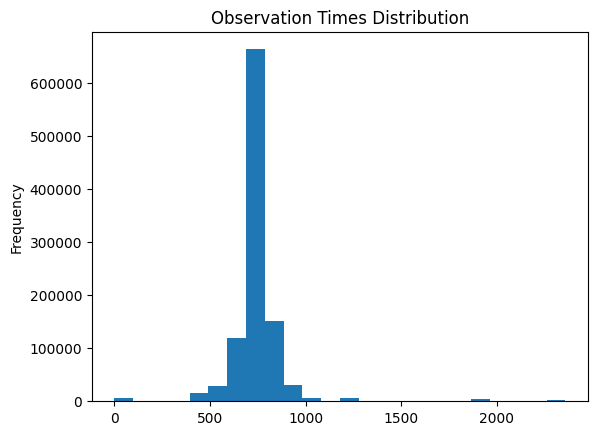

In [110]:
# Frequencies of the observation times
mn_data['OBS_TIME'].plot(kind='hist', bins=24, title='Observation Times Distribution');

In [111]:
# Elevation Statistics of the stations in Minnesota
mn_station_metadata['Elevation'].astype(float).describe()

count    587.000000
mean     328.239182
std       62.924338
min      187.500000
25%      278.600000
50%      306.300000
75%      381.150000
max      581.900000
Name: Elevation, dtype: float64

# 3. **Statistical Analysis:** 


   - Applying statistical methods to investigate climate anomalies.  
   - Comparing long-term trends across the selected time periods.

In [112]:
# Columns we will be analyzing for the weather data
columns_of_interest = 'PRCP', 'SNOW', 'SNWD', 'WESD', 'WESF', 'DAPR', 'MDPR'

# Column of interest common names for easier understanding
common_names = {
    'PRCP': 'Precipitation',
    'SNOW': 'Snowfall',
    'SNWD': 'Snow Depth',
    'WESD': 'Water Equivalent of Snow on the Ground',
    'WESF': 'Water Equivalent of Snowfall',
    'DAPR': 'Number of Days Included in Multiday Precipitation Total',
    'MDPR': 'Multiday Precipitation Total'
}

#### Inspect seasonailty of all the measurements

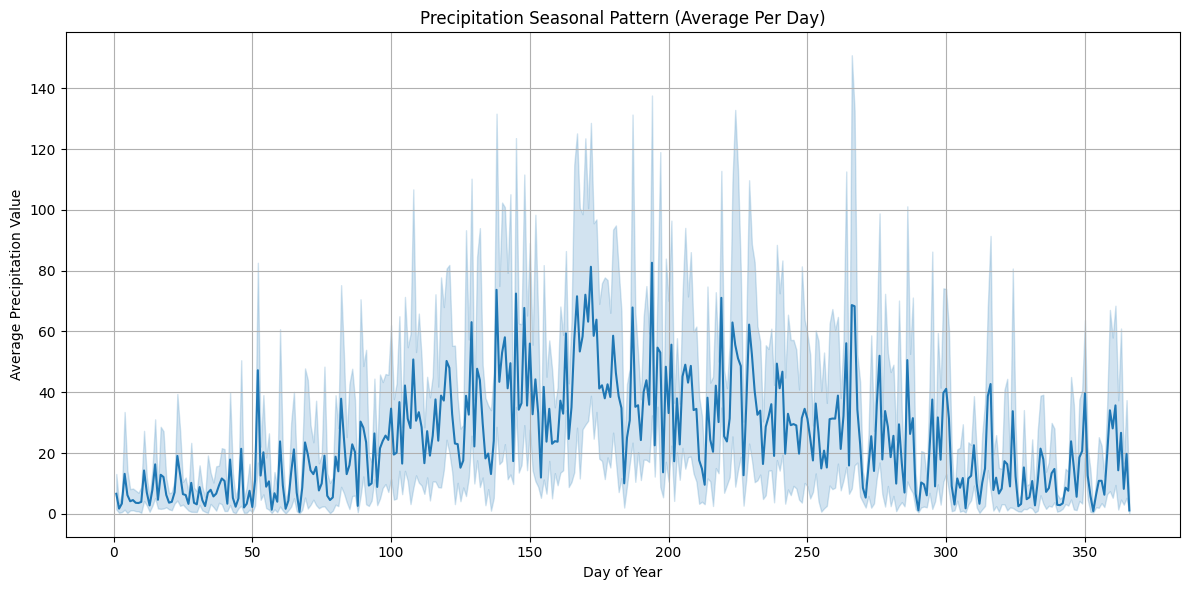

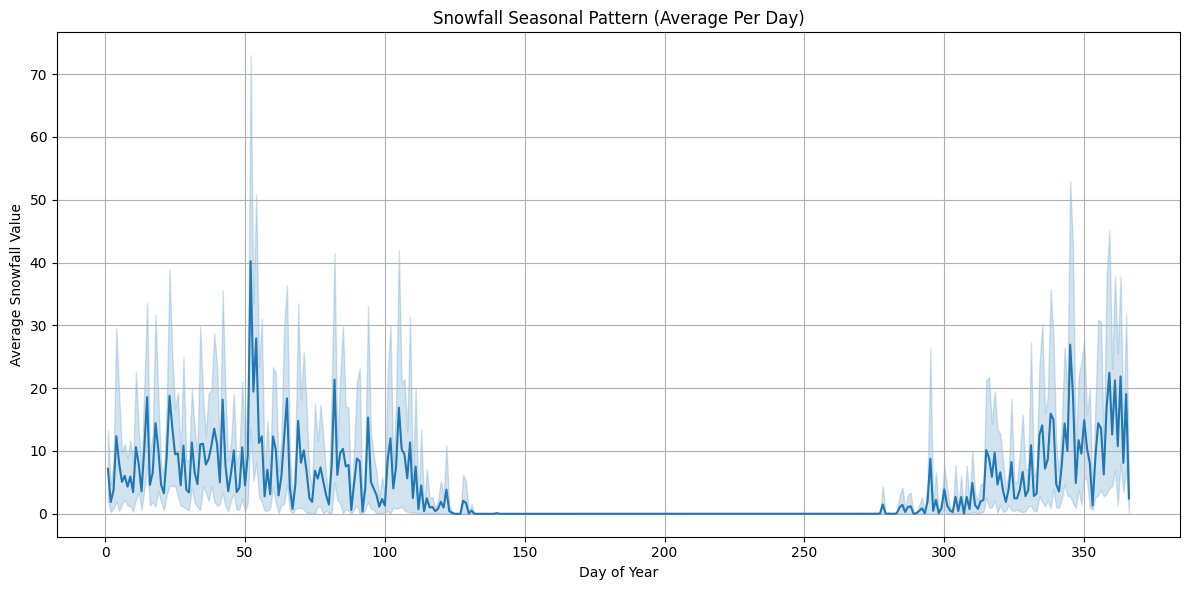

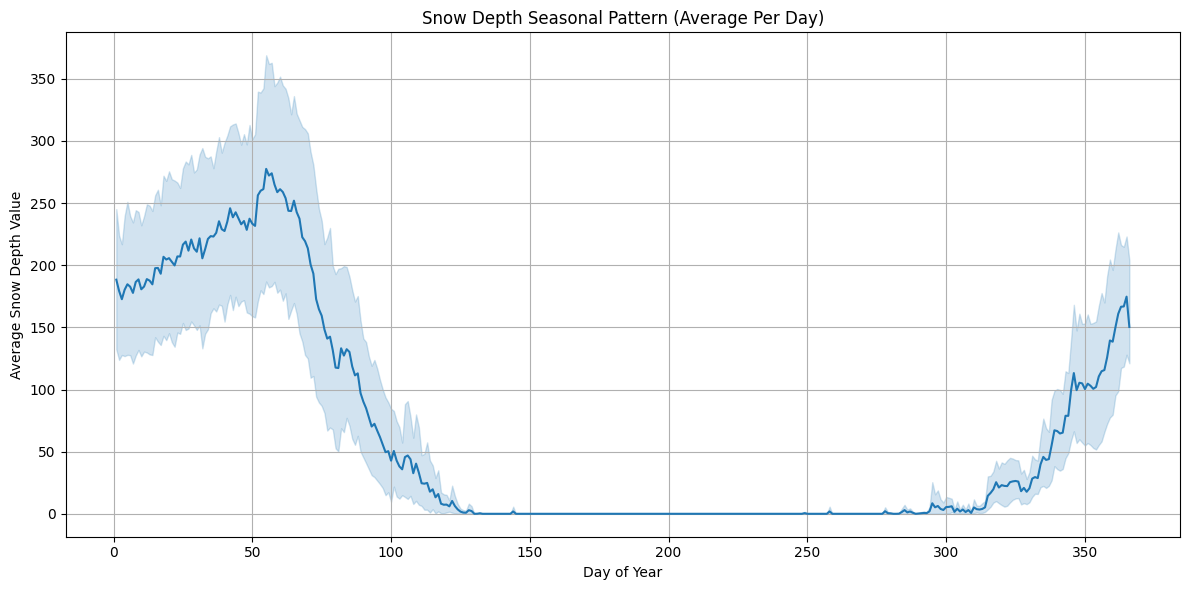

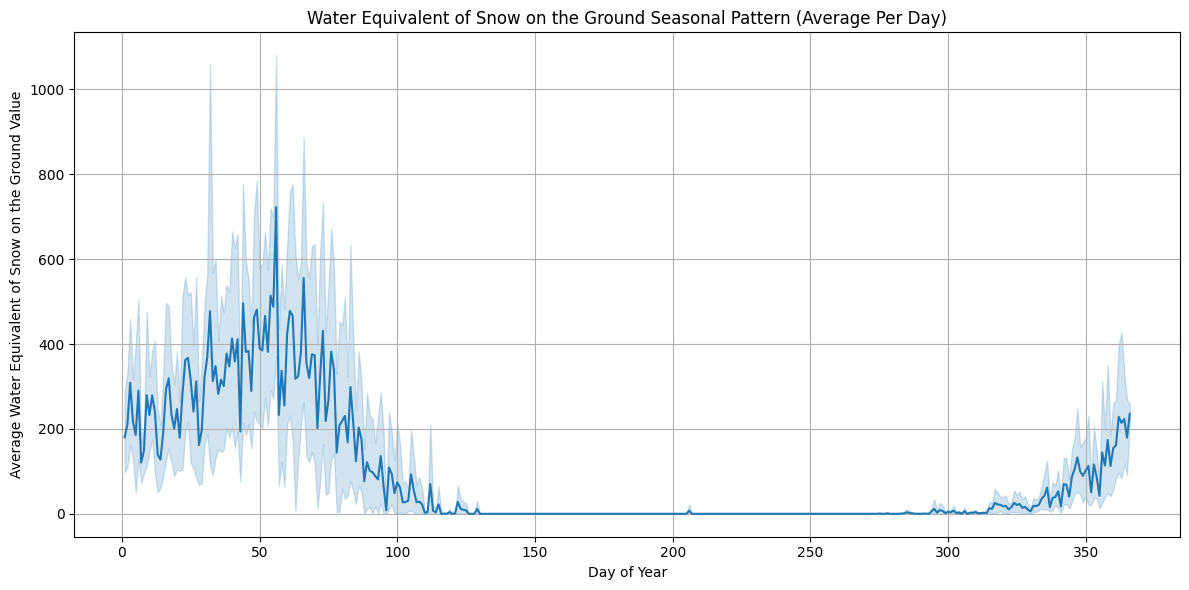

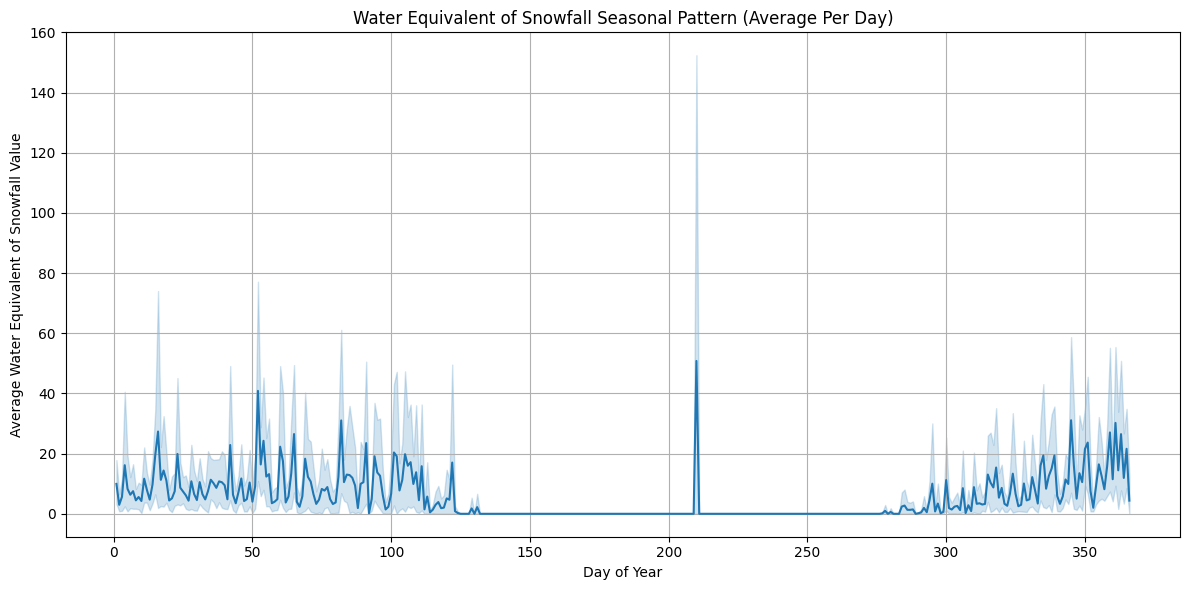

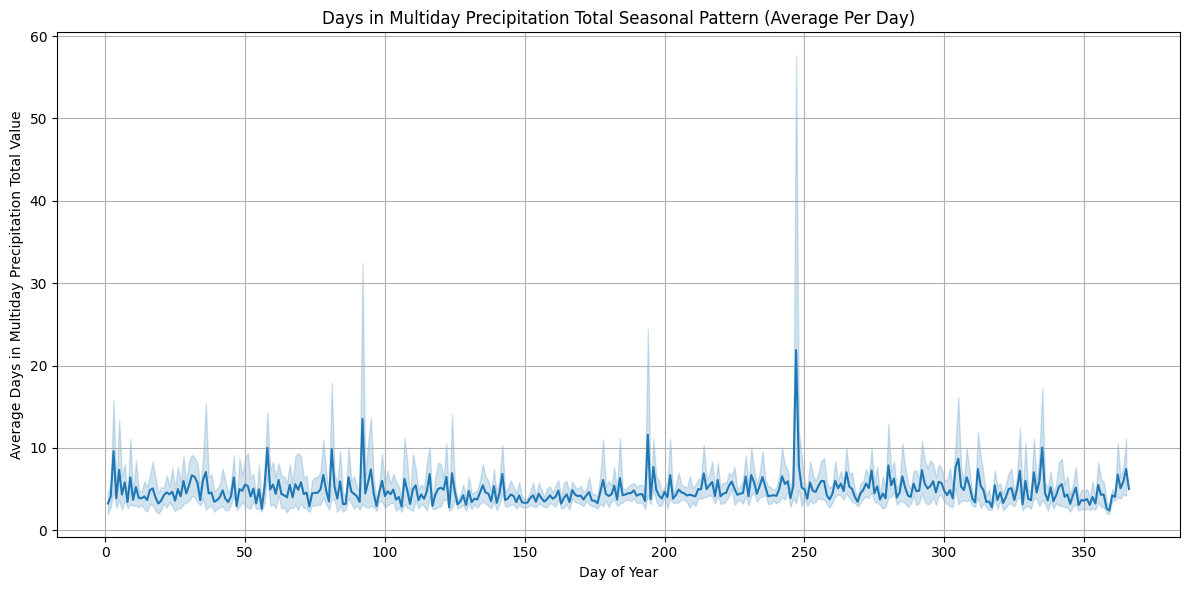

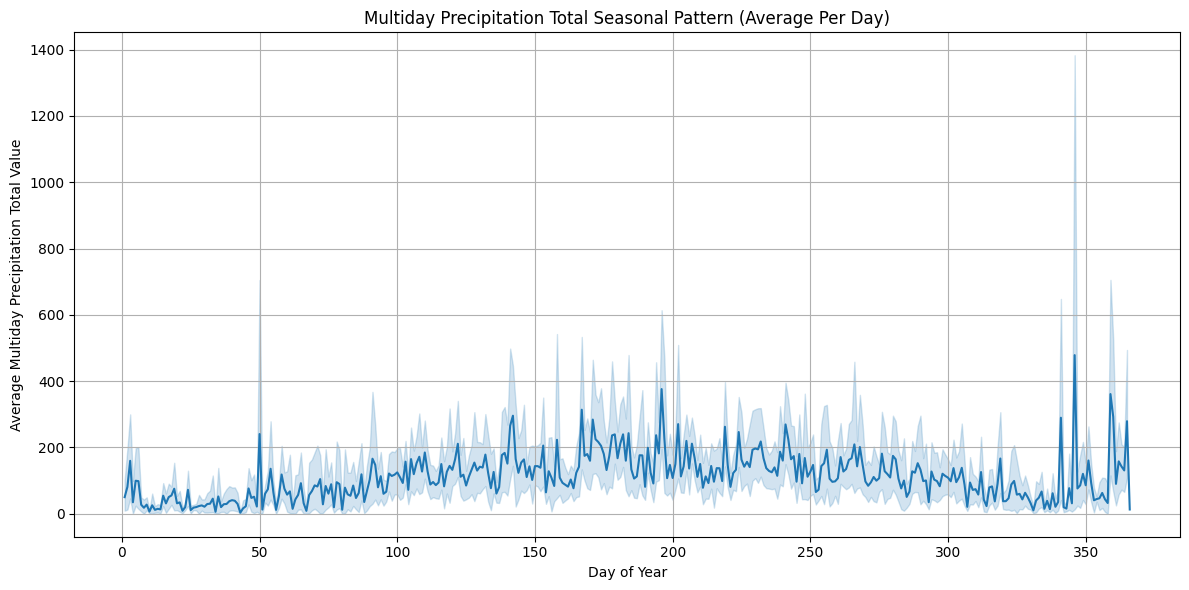

In [113]:
# Ensure the DATE column is in datetime format
mn_data['DATE'] = pd.to_datetime(mn_data['DATE'], format='%Y%m%d')

# Column of interest common names for easier understanding
common_names = {
    'PRCP': 'Precipitation',
    'SNOW': 'Snowfall',
    'SNWD': 'Snow Depth',
    'WESD': 'Water Equivalent of Snow on the Ground',
    'WESF': 'Water Equivalent of Snowfall',
    'DAPR': 'Days in Multiday Precipitation Total',
    'MDPR': 'Multiday Precipitation Total'
}

# Plot the trends for the columns of interest
for column in columns_of_interest:
    # Get the common name for the column of interest
    common_name = common_names.get(column, column)

    # Filter the data for the current element
    column_data = mn_data[mn_data['ELEMENT'] == column]

    # Aggregate the mean by date
    daily_avg = column_data.groupby('DATE')['DATA_VALUE'].mean().reset_index()

    # Add a column for day of year (DOY) to emphasize seasonality
    daily_avg['DOY'] = daily_avg['DATE'].dt.dayofyear

    # Plot the seasonal pattern using DOY
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=daily_avg, x='DOY', y='DATA_VALUE')
    plt.title(f'{common_name} Seasonal Pattern (Average Per Day)')
    plt.xlabel('Day of Year')
    plt.ylabel(f'Average {common_name} Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [114]:
# Statistically compare the months against each other using Tukey HSD for each column of interest
for column in columns_of_interest:
    # Get the common name for the column of interest
    common_name = common_names.get(column, column)

    # Filter the data for the current element
    column_data = mn_data[mn_data['ELEMENT'] == column]

    # Extract month and data values for Tukey's HSD test
    column_data.loc[:, 'MONTH'] = column_data['DATE'].dt.month

    # Perform Tukey's HSD test using raw data
    try:
        tukey_results = pairwise_tukeyhsd(column_data['DATA_VALUE'], column_data['MONTH'])
        print(f"Tukey HSD Test for {common_name} by Month:")
        print(tukey_results)
        print()
    except Exception as e:
        print(f"Error performing Tukey HSD for {common_name}: {e}")

/var/folders/w5/2z3_2xd934z0ryjywh4_05wr0000gn/T/ipykernel_1566/631508801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column_data.loc[:, 'MONTH'] = column_data['DATE'].dt.month
/var/folders/w5/2z3_2xd934z0ryjywh4_05wr0000gn/T/ipykernel_1566/631508801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column_data.loc[:, 'MONTH'] = column_data['DATE'].dt.month
/var/folders/w5/2z3_2xd934z0ryjywh4_05wr0000gn/T/ipykernel_1566/631508801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a c

Tukey HSD Test for Precipitation by Month:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2   2.6347 0.0076   0.3763   4.8931   True
     1      3  10.1264    0.0    7.968  12.2848   True
     1      4  23.9838    0.0  22.0028  25.9648   True
     1      5  33.4525    0.0  31.5564  35.3486   True
     1      6  38.3288    0.0  36.4314  40.2261   True
     1      7   28.989    0.0  27.0997  30.8784   True
     1      8  34.6242    0.0  32.7351  36.5134   True
     1      9   21.642    0.0  19.7331   23.551   True
     1     10  17.6131    0.0   15.689  19.5371   True
     1     11   8.8938    0.0   6.8554  10.9322   True
     1     12   8.4616    0.0   6.3172   10.606   True
     2      3   7.4917    0.0   5.2632   9.7201   True
     2      4  21.3491    0.0  19.2919  23.4062   True
     2      5  30.8178    0.0  28.8422  32.7933   True
     2      6   35.694

/var/folders/w5/2z3_2xd934z0ryjywh4_05wr0000gn/T/ipykernel_1566/631508801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column_data.loc[:, 'MONTH'] = column_data['DATE'].dt.month
/opt/homebrew/Caskroom/miniforge/base/envs/env_torch2/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Tukey HSD Test for Water Equivalent of Snow on the Ground by Month:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     1      2   98.9851    0.0   66.7271  131.2432   True
     1      3   -1.1993    1.0   -30.091   27.6923  False
     1      4 -189.9253    0.0 -217.8579 -161.9926   True
     1      5 -243.2343    0.0 -271.5664 -214.9022   True
     1      6 -246.1727    0.0 -275.2313  -217.114   True
     1      7  -246.103    0.0 -275.2797 -216.9262   True
     1      8 -246.1727    0.0 -275.7777 -216.5677   True
     1      9 -246.1727    0.0  -275.205 -217.1404   True
     1     10 -242.1424    0.0 -269.7595 -214.5253   True
     1     11 -233.0403    0.0 -260.2974 -205.7832   True
     1     12 -173.9568    0.0 -203.2745 -144.6391   True
     2      3 -100.1844    0.0 -128.4892  -71.8797   True
     2      4 -288.9104    0.0 -316.2356 -261.5852   True
    

/var/folders/w5/2z3_2xd934z0ryjywh4_05wr0000gn/T/ipykernel_1566/631508801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column_data.loc[:, 'MONTH'] = column_data['DATE'].dt.month


Tukey HSD Test for Water Equivalent of Snowfall by Month:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2   2.3351 0.0849  -0.1356   4.8058  False
     1      3   5.0075    0.0   2.4879    7.527   True
     1      4   4.2575    0.0   1.5739   6.9411   True
     1      5 -13.6991    0.0  -16.812 -10.5863   True
     1      6 -15.1806    0.0  -18.492 -11.8693   True
     1      7 -14.1776    0.0  -17.513 -10.8422   True
     1      8 -15.1806    0.0 -18.5171 -11.8442   True
     1      9 -15.1806    0.0 -18.5534 -11.8079   True
     1     10  -9.2519    0.0 -12.1511  -6.3527   True
     1     11  -2.5624 0.0444  -5.0953  -0.0296   True
     1     12   7.8198    0.0   5.4352  10.2044   True
     2      3   2.6724 0.0367   0.0781   5.2666   True
     2      4   1.9224 0.4899  -0.8315   4.6762  False
     2      5 -16.0342    0.0 -19.2078 -12.8607   True
     2 

/var/folders/w5/2z3_2xd934z0ryjywh4_05wr0000gn/T/ipykernel_1566/631508801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column_data.loc[:, 'MONTH'] = column_data['DATE'].dt.month


Tukey HSD Test for Days in Multiday Precipitation Total by Month:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.4001 0.9997 -1.2264 2.0267  False
     1      3   0.2044    1.0 -1.3846 1.7933  False
     1      4  -0.2052    1.0  -1.551 1.1407  False
     1      5  -0.7455 0.7583 -2.0268 0.5357  False
     1      6  -0.6832 0.8476 -1.9634 0.5971  False
     1      7    0.005    1.0 -1.2793 1.2893  False
     1      8   0.1418    1.0 -1.1433 1.4268  False
     1      9    0.429 0.9954 -0.8647 1.7227  False
     1     10   0.1947    1.0 -1.1068 1.4963  False
     1     11  -0.0727    1.0 -1.4896 1.3443  False
     1     12  -0.0057    1.0 -1.4859 1.4745  False
     2      3  -0.1958    1.0 -1.8171 1.4256  False
     2      4  -0.6053 0.9579 -1.9892 0.7787  False
     2      5  -1.1457 0.1657 -2.4669 0.1756  False
     2      6  -1.0833 0.2352 -2.4035  0.237  Fals

/var/folders/w5/2z3_2xd934z0ryjywh4_05wr0000gn/T/ipykernel_1566/631508801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column_data.loc[:, 'MONTH'] = column_data['DATE'].dt.month


Tukey HSD Test for Multiday Precipitation Total by Month:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
     1      2    8.1749    1.0  -43.6731  60.0228  False
     1      3   33.7884   0.55  -16.4255  84.0024  False
     1      4   95.6948    0.0   53.2135 138.1761   True
     1      5  129.7498    0.0   89.2898 170.2098   True
     1      6  140.5753    0.0  100.1817 180.9689   True
     1      7  114.4949    0.0   73.9446 155.0452   True
     1      8  130.4507    0.0   89.8856 171.0158   True
     1      9  100.2677    0.0   59.4492 141.0862   True
     1     10   91.8752    0.0   50.7797 132.9707   True
     1     11   32.7562 0.4125  -12.0347  77.5471  False
     1     12    83.435    0.0   36.5569 130.3131   True
     2      3   25.6136 0.9005  -25.9291  77.1563  False
     2      4   87.5199    0.0    43.476 131.5638   True
     2      5   121.575    0.0

#### Compare the mean values of each measurement across different months

In [115]:
# Compare the means 
mn_data['DATE'] = pd.to_datetime(mn_data['DATE'], format='%Y%m%d')

# Add a 'MONTH' column
mn_data['MONTH'] = mn_data['DATE'].dt.month


monthly_means_table = {}

for column in columns_of_interest:
    # Filter for the current column of interest
    column_data = mn_data[mn_data['ELEMENT'] == column]

    # Group by month 
    monthly_means = column_data.groupby('MONTH')['DATA_VALUE'].mean()

    # Add the results
    monthly_means_table[column] = monthly_means
    
monthly_means_df = pd.DataFrame(monthly_means_table)

monthly_means_df.index = pd.to_datetime(monthly_means_df.index, format='%m').month_name()

print("Mean Measurements by Month:")
monthly_means_df

Mean Measurements by Month:


,PRCP,SNOW,SNWD,WESD,WESF,DAPR,MDPR
MONTH,,,,,,,
January,7.544536,8.308998,179.872556,246.172678,15.180644,4.672973,43.445070
February,10.179276,10.058576,219.487152,345.157787,17.515757,5.073099,51.619938
March,17.670942,8.105005,183.445633,244.973349,20.188113,4.877333,77.233516
April,31.528339,4.805381,55.219844,56.247402,19.438119,4.467816,139.139860
May,40.997045,0.138053,2.014590,2.938378,1.481508,3.927445,173.194909
June,45.873309,0.000000,0.000000,0.000000,0.000000,3.989820,184.020376
July,36.533576,0.000000,0.000000,0.069693,1.003072,4.677939,157.939935
August,42.168779,0.000000,0.000000,0.000000,0.000000,4.814725,173.895765
September,29.186564,0.000000,0.084162,0.000000,0.000000,5.101971,143.712812


# 4. **Results and Discussion:**  

### Summary of Monthly Mean Measurements

The table below summarizes the monthly mean measurements for various weather elements recorded across Minnesota stations. Key insights are provided for each variable to highlight seasonal trends and variations.

---

#### **Variables and Key Observations**

1. **Precipitation (`PRCP`)**
   - **Highest:** June (45.92 mm) and August (42.22 mm), indicating peak rainfall during summer.
   - **Lowest:** January (7.54 mm) and February (10.19 mm), consistent with winter conditions.

2. **Snowfall (`SNOW`)**
   - **Dominant:** December (12.27 mm), February (10.06 mm), and January (8.31 mm), reflecting winter accumulation.
   - **Absent:** May to September.

3. **Snow Depth (`SNWD`)**
   - **Peaks:** February (219.34 mm) and January (179.92 mm), reflecting snowpack during colder months.
   - **Minimal:** Late spring and summer.

4. **Water Equivalent of Snow on the Ground (`WESD`)**
   - **Highest:** February (345.35 mm), with significant values in January (246.17 mm) and March (240.94 mm).
   - **Negligible:** May through September.

5. **Water Equivalent of Snowfall (`WESF`)**
   - **Peaks:** December (23.44 mm) and March (20.39 mm), aligning with active snowfall periods.
   - **Low values:** Outside the winter months.

6. **Number of Days in Multiday Precipitation Total (`DAPR`)**
   - **Stable:** Ranges from 3.94 days (May) to 5.09 days (September).

7. **Multiday Precipitation Total (`MDPR`)**
   - **Peaks:** June (184.50 mm) and May (173.98 mm), reflecting extended rain events during late spring and early summer.
   - **Lowest:** January (44.74 mm).

---

#### **Seasonal Highlights**

- **Winter (December to February)**
  - High snowfall and snow depth dominate.
  - Minimal precipitation as rain.

- **Spring (March to May)**
  - Transition from snow to rain, with increasing precipitation totals.
  - Snow depth diminishes by May.

- **Summer (June to August)**
  - Highest precipitation totals, predominantly as rain.
  - Snowfall and snow-related variables are negligible.

- **Autumn (September to November)**
  - Gradual reduction in rainfall.
  - Snowfall begins to reappear in late autumn, particularly in November.

---

#### **Usage**
This data provides an excellent foundation for analyzing seasonal weather patterns in Minnesota, aiding in climate studies, agricultural planning, and hydrological modeling. The high-resolution temporal trends can also inform decision-making for infrastructure maintenance and disaster preparedness.

# 5. **Conclusion**

The analysis of monthly mean measurements across Minnesota highlights significant seasonal patterns in precipitation, snowfall, and related variables. Key insights include:

- **Winter Dominance**: High snowfall and snow depth are observed in December through February, with water equivalents providing a deeper understanding of snowpack accumulation.
- **Summer Precipitation Peaks**: Precipitation values peak in June and August, aligning with expected summer rainfall trends, while snow-related variables become negligible.
- **Transition Periods**: Spring and autumn exhibit transitional behaviors, with snowfall diminishing in spring and reappearing in late autumn.

These findings serve as a foundation for understanding Minnesota's climate dynamics, with potential applications in agriculture, water resource management, and disaster preparedness.

#### **Potential Areas for Further Study**
- Investigate interannual variability by comparing trends over multiple years.
- Explore the relationship between observed variables and external factors such as elevation, or station-specific geography.
- Incorporate machine learning models to predict future seasonal trends and anomalies based on historical data.